# Alineamientos

Funcion para crear el dotplot.
(DUDA: EN EL GRAFICO DE LA CLASE SE VEÍA DIFERENTE CON UN EJEMPLO... CONSULTAR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.Align import substitution_matrices
from Bio.Phylo.TreeConstruction import DistanceCalculator


def show_dotplot(dotplot, k=0, show_values=False):
    plt.imshow(dotplot, cmap="gray_r", interpolation='nearest')
    if k!=0:
        k_message = f"k={k}"
    else:
        k_message = "SIN FILTRAR"
        
    if show_values:
        for i in range(len(dotplot)):
            for j in range(len(dotplot[0])):
                value = dotplot[i][j]
                plt.text(j, i, f'{value:.1f}', ha='center', va='center', color='red', fontsize=8)

    plt.title(f'Dotplot: {len(dotplot)} elementos vs {len(dotplot[0])} elementos | {k_message}')
    
    plt.xlabel("Secuencia 2")
    plt.ylabel("Secuencia 1")
    plt.show()
    
def make_dotplot(seq1, seq2, t):
    dotplot = np.zeros((len(seq1),len(seq2)))
        
    for i in range(len(seq1)):
        for j in range(len(seq2)):
            if t=='ADN':
                if seq1[i]==seq2[j]:
                    dotplot[i,j] = 1
            else:
                dotplot[i,j] = substitution_matrices.load('BLOSUM62')[seq1[i],seq2[j]]
                    
    return dotplot

Funcion para filtrar el dotplot

In [3]:
def has_potential(subdotplot, threshold):
    score = 0
    for i in range(len(subdotplot)):
        score += subdotplot[i,i]

    if score > threshold:
        return True
    return False

def filtered_dotplot(dotplot, k, t, threshold):
    """
    Filtra una matriz de dotplot resaltando las regiones diagonales de tamaño k con mayor puntuación.
    
    La función evalúa las submatrices de tamaño `k x k` dentro de la matriz `dotplot`, buscando aquellas que tienen un número mayoritario de unos en su diagonal principal. Si la submatriz cumple con el criterio, se añade al dotplot filtrado.
    
    Args:
        dotplot (numpy.ndarray): La matriz original de dotplot que se analizará.
        k (int): El tamaño de la submatriz cuadrada a evaluar.
        t (str): Tipo de secuencia ('PROTEIN' o 'DNA').
        threshold (int): Umbral mínimo para determinar si un alineamiento es válido. Representa la puntuación mínima necesaria para considerar un alineamiento como factible.
    Returns:
        numpy.ndarray: Una nueva matriz del mismo tamaño que `dotplot`, donde las regiones que cumplen con 
        el criterio están resaltadas con unos en la diagonal.
    
    Raises:
        ValueError: Si `k` es mayor que las dimensiones de la matriz `dotplot`.
    """
    rows, cols = len(dotplot), len(dotplot[0])
    f_dotplot = np.zeros((rows, cols))

    for i in range(rows-k+1):
        for j in range(cols-k+1):
            sub_dotplot = dotplot[i:i+k, j:j+k]
            if has_potential(sub_dotplot, threshold):
                if t=='ADN':
                    f_dotplot[i:i+k, j:j+k] = sub_dotplot * np.eye(k)
                elif t=='PROTEIN':
                    f_dotplot[i,j]=1

    return f_dotplot
            

Funcion para encontrar el mejor alineamiento posible... (una especie de greedy, hecho rapido, tiene muchos 'huecos')

In [4]:
def obtain_best_alignment(dotplot):
    complete = False
    alignment_list = []
    i = 0
    j = 0
    while not complete:
        if i >= len(dotplot) or j >= len(dotplot[0]):
            complete = True
        else:
            alignment_list.append([i, j])
            if i + 1 < len(dotplot) and j + 1 < len(dotplot[0]) and dotplot[i + 1, j + 1] == 1:
                i += 1
                j += 1
            elif j + 1 < len(dotplot[0]) and dotplot[i, j + 1] == 1:
                j += 1
            elif i + 1 < len(dotplot) and dotplot[i + 1, j] == 1:
                i += 1
            else:
                j += 1
    return alignment_list


Traduccion de la lista de alineamientos a una sintaxis mas amigable

In [5]:
def traduce_alignment(alignment_list, seq1, seq2):
    traduced_seq = ''
    for i in range(len(alignment_list)):
        if seq1[alignment_list[i][0]] == seq2[alignment_list[i][1]]:
                traduced_seq += f"{seq1[alignment_list[i][0]]}{i}"
        else:
            # traduced_seq += f"{seq1[alignment_list[i-1][0]]}"
            # Si se prefiere un guion en vez de repetir la ultima base:
            traduced_seq += "-"
    return traduced_seq
    

Funcion de alineamiento de secuencias

In [6]:
from Bio import SeqIO

def read_fasta(filename):
    with open(filename,'r') as handle:
        r_seq = list(SeqIO.parse(handle, 'fasta'))
        return r_seq[0].seq, r_seq[1].seq

In [38]:
def obtain_threshold(seq1, seq2, t):
    t_dotplot1, t_dotplot2 = make_dotplot(seq1, seq1, t), make_dotplot(seq2, seq2, t)
    i=0
    j=0
    threshold1, threshold2 = 0, 0
    
    while i < len(t_dotplot1) and j < len(t_dotplot1[0]):
        threshold1 += t_dotplot1[i, j]
        i+=1
        j+=1
    i=0
    j=0
    while i < len(t_dotplot2) and j < len(t_dotplot2[0]):
        threshold2 += t_dotplot2[i, j]
        i+=1
        j+=1
    threshold = ((threshold1/len(seq1)) + (threshold2/len(seq2))/2)
    
    return threshold
    

In [39]:
def get_score(alignment, dotplot):
    score = 0.0
    for coord in alignment:
        score += dotplot[coord[0]][coord[1]]
    return score

In [40]:
def alignment(seq1, seq2, k, t, threshold=0, score=False):
    """
    Genera la mejor alineación entre dos secuencias utilizando un dotplot filtrado.
    
    Args:
        seq1 (str): Primera secuencia a alinear.
        seq2 (str): Segunda secuencia a alinear.
        k (int): Tamaño de las submatrices cuadradas utilizadas en el filtrado del dotplot.
        t (str): Tipo de secuencia ('PROTEIN' o 'DNA').
    
    Returns:
        tuple: Una tupla que contiene la alineación traducida, el dotplot original, y el dotplot filtrado.
    
    Raises:
        ValueError: Si el tamaño `k` es mayor que las dimensiones de la matriz `dotplot`.
    """
    
    if t == 'ADN':
        threshold = (k/2)
    elif threshold==0:
        threshold = obtain_threshold(seq1, seq2, t)
        
    if k > len(seq1) or k > len(seq2):
        raise ValueError(f"El tamaño 'k' ({k}) es mayor que las dimensiones de la matriz dotplot.")

    dotplot = make_dotplot(seq1, seq2, t)
    f_dotplot = filtered_dotplot(dotplot, k, t, threshold)
    best_alignment = obtain_best_alignment(f_dotplot)
    traduced_alignment = traduce_alignment(best_alignment, seq1, seq2)
    if score:
        s = get_score(best_alignment, dotplot)
        return traduced_alignment, dotplot, f_dotplot, s
    return traduced_alignment, dotplot, f_dotplot


In [10]:
file = "./documents/TP53.fna"
seq1, seq2 = read_fasta(file)
seq1, seq2 = seq1[:1000], seq2[:1000]

# Ventana de filtrado de alineamientos:
k = 30

align, dotplot, f_dotplot = alignment(seq1, seq2, k, "ADN")

# seq1 = 'TACG'
# seq2 = 'TATCG'
# k = 3
# threshold = (k/2)
# align, dotplot, f_dotplot = alignment(seq1, seq2, k, "ADN", threshold)

# RESULTADOS

#### Dotplot sin filtrar

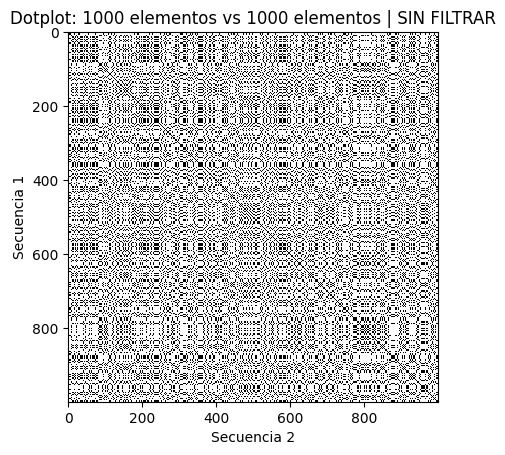

In [11]:
show_dotplot(dotplot)

#### Dotplot filtrado

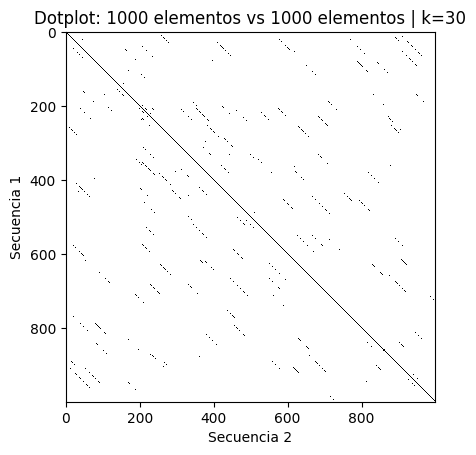

In [12]:
show_dotplot(f_dotplot, k)

#### Mejor alineamiento

In [13]:
print(align)

C0T1C2A3A4A5A6G7T8C9T10A11G12A13G14C15C16A17C18C19G20T21C22C23A24G25G26G27A28G29C30A31G32G33T34A35G36C37T38G39C40T41G42G43G44C45T46C47C48G49G50G51G52A53C54A55C56T57T58T59G60C61G62T63T64C65G66G67G68C69T70G71G72G73A74G75C76G77T78G79C80T81T82T83C84C85A86C87G88A89C90G91G92T93G94A95C96A97C98G99C100T101T102C103C104C105T106G107G108A109T110T111G112G113G114T115A116A117G118C119T120C121C122T123G124A125C126T127G128A129A130C131T132T133G134A135T136G137A138G139T140C141C142T143C144T145C146T147G148A149G150T151C152A153C154G155G156G157C158T159C160T161C162G163G164C165T166C167C168G169T170G171T172A173T174T175T176T177C178A179G180C181T182C183G184G185G186A187A188A189A190T191C192G193C194T195G196G197G198G199C200T201G202G203G204G205G206T207G208G209G210G211C212A213G214T215G216G217G218G219A220C221T222T223A224G225C226G227A228G229T230T231T232G233G234G235G236G237T238G239A240G241T242G243G244G245A246T247G248G249A250A251G252C253T254T255G256G257C258T259A260G261A262G263G264G265A266T267C268A269T270C271A272T273A274G275G276A2

### Comparación con Biopython

Función de alineamiento de biopython

In [14]:
from Bio import pairwise2

# Realizar el alineamiento
al = pairwise2.align.globalxx(seq1, seq2)

# Imprimir los alineamientos
for a in al:
    print(pairwise2.format_alignment(*a))

CTCAAAAGTCTAGAGCCACCGTCCAGGGAGCAGGTAGCTGCTGGGCTCCGGGGACACTTTGCGTTCGGGCTGGGAGCGTGCTTTCCACGACGGTGACACGCTTCCCTGGATTGGGTAAGCTCCTGACTGAACTTGATGAGTCCTCTCTGAGTCACGGGCTCTCGGCTCCGTGTATTTTCAGCTCGGGAAAATCGCTGGGGCTGGGGGTGGGGCAGTGGGGACTTAGCGAGTTTGGGGGTGAGTGGGATGGAAGCTTGGCTAGAGGGATCATCATAGGAGTTGCATTGTTGGGAGACCTGGGTGTAGATGATGGGGATGTTAGGACCATCCGAACTCAAAGTTGAACGCCTAGGCAGAGGAGTGGAGCTTTGGGGAACCTTGAGCCGGCCTAAAGCGTACTTCTTTGCACATCCACCCGGTGCTGGGCGTAGGGAATCCCTGAAATAAAAGATGCACAAAGCATTGAGGTCTGAGACTTTTGGATCTCGAAACATTGAGAACTCATAGCTGTATATTTTAGAGCCCATGGCATCCTAGTGAAAACTGGGGCTCCATTCCGAAATGATCATTTGGGGGTGATCCGGGGAGCCCAAGCTGCTAAGGTCCCACAACTTCCGGACCTTTGTCCTTCCTGGAGCGATCTTTCCAGGCAGCCCCCGGCTCCGCTAGATGGAGAAAATCCAATTGAAGGCTGTCAGTCGTGGAAGTGAGAAGTGCTAAACCAGGGGTTTGCCCGCCAGGCCGAGGAGGACCGTCGCAATCTGAGAGGCCCGGCAGCCCTGTTATTGTTTGGCTCCACATTTACATTTCTGCCTCTTGCAGCAGCATTTCCGGTTTCTTTTTGCCGGAGCAGCTCACTATTCACCCGATGAGAGGGGAGGAGAGAGAGAGAAAATGTCCTTTAGGCCGGTTCCTCTTACTTGGCAGAGGGAGGCTGCTATTCTCCGCCTGCATTTCTTTTTCTGGATTACTTAGTTATGGCCTTTGCAAAGGCAGGGGT

/home/agustin/Escritorio/Bioinformatica/TPs/bioinformatics/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# ALINEAMIENTO DE PROTEINAS

Utilizamos la misma funcion pero enviando 'PROTEIN' en el parametro t (tipo).

Y cargamos una proteina existente, tomando como primer secuencia los primeros 100 aminoacidos y en la segunda secuencia los primeros 150... para corroborar que haya match en los primeros 100.

In [41]:
prot = SeqIO.read("./documents/my_prot.txt","swiss")
prot_seq1 = prot.seq[:100]
prot_seq2 = prot.seq[:150]
prot_k=3

# Threshold es opcional. Si no se le envia nada en ese parametro, la funcion calculara el umbral en base a la media del score de la diagonal principal de la primer secuencia
prot_align, prot_dotplot, prot_f_dotplot, score = alignment(prot_seq1, prot_seq2, prot_k, 'PROTEIN', score=True)

Grafico Sin filtrar

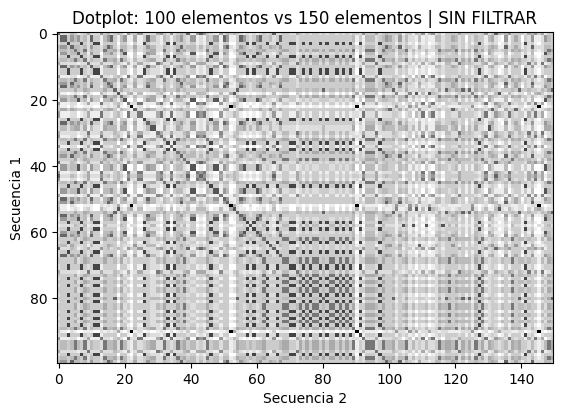

In [42]:
show_dotplot(prot_dotplot)

Grafico filtrado

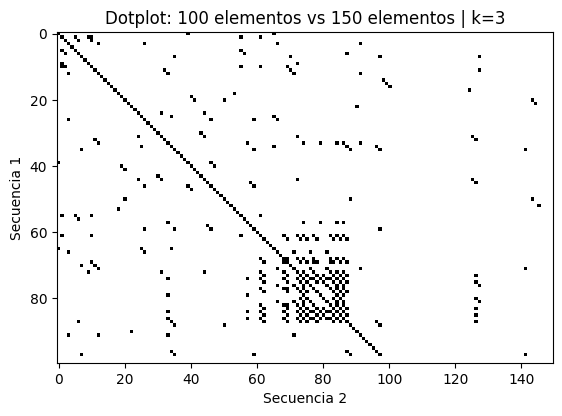

In [43]:
show_dotplot(prot_f_dotplot, prot_k)

Mejor alineamiento

In [21]:
print(prot_align)

M0E1E2P3Q4S5D6P7S8V9E10P11P12L13S14Q15E16T17F18S19D20L21W22K23L24L25P26E27N28N29V30L31S32P33L34P35S36Q37A38M39D40D41L42M43L44S45P46D47D48I49E50Q51W52F53T54E55D56P57G58P59D60E61A62P63R64M65P66E67A68A69P70P71V72A73P74A75P76A77A78P79T80P81A82A83P84A85P86A87P88S89W90P91L92S93S94S95V96P97-----------------------------P127-------------P141--------


In [22]:
print(score)

449.0


# ALINEAMIENTO MULTIPLE

Obtenemos secuencias de proteinas con una funcion simple

In [23]:
def obtain_protein_sequence(prot,k):
    sequences = []
    i = 0
    num_of_seq = 1
    while i<=(len(prot)-k):
        sequences.append([prot.seq[i:i+k], f"seq{num_of_seq}"])
        num_of_seq += 1
        i+=k
    return sequences

In [24]:
sequences = obtain_protein_sequence(prot,30)

print(sequences)

[[Seq('MEEPQSDPSVEPPLSQETFSDLWKLLPENN'), 'seq1'], [Seq('VLSPLPSQAMDDLMLSPDDIEQWFTEDPGP'), 'seq2'], [Seq('DEAPRMPEAAPPVAPAPAAPTPAAPAPAPS'), 'seq3'], [Seq('WPLSSSVPSQKTYQGSYGFRLGFLHSGTAK'), 'seq4'], [Seq('SVTCTYSPALNKMFCQLAKTCPVQLWVDST'), 'seq5'], [Seq('PPPGTRVRAMAIYKQSQHMTEVVRRCPHHE'), 'seq6'], [Seq('RCSDSDGLAPPQHLIRVEGNLRVEYLDDRN'), 'seq7'], [Seq('TFRHSVVVPYEPPEVGSDCTTIHYNYMCNS'), 'seq8'], [Seq('SCMGGMNRRPILTIITLEDSSGNLLGRNSF'), 'seq9'], [Seq('EVRVCACPGRDRRTEEENLRKKGEPHHELP'), 'seq10'], [Seq('PGSTKRALPNNTSSSPQPKKKPLDGEYFTL'), 'seq11'], [Seq('QIRGRERFEMFRELNEALELKDAQAGKEPG'), 'seq12'], [Seq('GSRAHSSHLKSKKGQSTSRHKKLMFKTEGP'), 'seq13']]


In [137]:
class AlignmentNode:

    def __init__(self, seq1, seq2):
        self.seq1 = seq1
        self.seq2 = seq2

    def __obtain_list_seqs(self, seq):
        if isinstance(seq, str):
            l = []
            i = 0
            while i < len(seq):
                if seq[i:i+3] == 'seq':  # Encuentra 'seq'
                    j = i + 3
                    # Encuentra el número después de 'seq'
                    while j < len(seq) and seq[j].isdigit():
                        j += 1
                    l.append(seq[i:j])  # Captura 'seq' seguido del número
                    i = j 
                else:
                    i += 1  # Avanza si no es 'seq'
            return l
        elif isinstance(seq, AlignmentNode):
            return seq.__obtain_list_seqs(seq.seq1)+(seq.__obtain_list_seqs(seq.seq2))

    def contains_seq(self, seq):
        list = self.__obtain_list_seqs(self)
        list2 = self.__obtain_list_seqs(seq)
        for seq1 in list: 
            for seq2 in list2:
                if seq1 == seq2:
                    return True
        return False
            
    
    def __str__(self):
        return f"({self.seq1}, {self.seq2})"



### Como calcular la matriz de distancia para el alineamiento multiple

1. **Buscar el par con menor distancia**

2. **Formar un nodo con esos elementos**

3. **Recalcula la matriz**: $$d(e1e2-j) = \frac{d(e1-j) + d(e2-j)}{2}$$

4. **Repetir el proceso**


In [131]:
from Bio import Phylo
from io import StringIO
import pandas as pd

class MultipleAlignment:   
    def __init__(self, sequences, type_of_sequences="ADN"):
        self.list_of_nodes = []
        self.alignments = ""
        self.matrix_history = []
        
        type_of_sequences = type_of_sequences.upper()
        if type_of_sequences == "ADN" or type_of_sequences == "PROTEIN":     
                self.type_of_sequences = type_of_sequences
        else:
            raise ValueError("type_of_sequences must be either ADN or PROTEIN")
        if self.__check_sequences(sequences):        
            self.matrix = self.__obtain_matrix(sequences)
        else:
            raise ValueError("sequence format must be like [[sequence],'name of sequence']")

    def __check_sequences(self, sequences):
        # Verificar que la lista contenga tuplas o listas con dos elementos
        if not isinstance(sequences, list):
            return False
    
        for item in sequences:
            if not isinstance(item, (tuple, list)) or len(item) != 2:
                return False
    
            sequence, name = item
            
            if self.type_of_sequences == "ADN":
                # Verificar que la secuencia sea una cadena que solo contenga A, T, C, G
                if not isinstance(sequence, str) or not all(base in 'ATCG' for base in sequence.upper()):
                    raise ValueError(f"The sequence type is: '{self.type_of_sequences}' but does not contain 'ATCG'")
                
            # Verificar que el nombre sea una cadena
            if not isinstance(name, str):
                raise ValueError(f"The name of the sequence must be a String")
    
        return True

        
    # Dibuja el dendograma
    def draw_tree(self):  
        tree = Phylo.read(StringIO(f"{self.alignments}"), "newick")
        tree.ladderize()
        Phylo.draw(tree)
    
    # Encuentra las secuencias con score mas cercano
    def __closest_neighbor(self,matrix):
        pair = []
        best_distance = -np.inf
        for i in range(len(matrix.index)):
            for j in range(i+1,len(matrix.columns)):
                distance = matrix.loc[matrix.index[i], matrix.columns[j]]
                if distance > best_distance:
                    pair=[matrix.index[i], matrix.columns[j]]
                    best_distance = matrix.loc[matrix.index[i], matrix.columns[j]]
        return pair[0], pair[1]
    
    # Revisa si existe el nodo, de ser asi lo devuelve
    def __check_if_exists_node(self, seq):
        r = None
        for node in self.list_of_nodes:
            if node.contains_seq(seq):
                r = node
            
        if r is None:
            return seq
        else:
            self.list_of_nodes.remove(r)
            return r
    
    # Se edita la matriz eliminando las columnas y las filas de los nodos conectados, y creando una nueva con el nodo nuevo.
    def __edit_matrix(self,matrix, row, column):
        seq1 = row
        seq2 = column
        
        df_copy = matrix.copy()
        matrix = matrix.drop(index=seq1, columns=seq2)
        matrix = matrix.drop(index=seq2, columns=seq1)
        
        align_node = AlignmentNode(self.__check_if_exists_node(seq1), self.__check_if_exists_node(seq2))
        self.list_of_nodes.append(align_node)
        # Insertar una columna llena de ceros en la posición dinámica
        
        matrix.insert(0, f'{align_node}', [0] * len(matrix))
        
        # Crear una fila llena de ceros para insertar con un nombre específico
        new_row = pd.DataFrame([[0] * len(matrix.columns)], columns=matrix.columns, index=[f'{align_node}'])
        
        # Insertar la fila en la posición dinámica
        matrix = pd.concat([new_row, matrix.iloc[0:]])

        matrix = matrix.astype(float)
        
        node1_str = str(align_node.seq1) 
        node2_str = str(align_node.seq2)
        
        # Reasigna valores a la matriz (en las filas y columnas nuevas hace la formula mencionada en el markdown de arriba)
        for i in range(len(matrix.index)):
            for j in range(i+1,len(matrix.columns)): 
                if matrix.index[i] == f"{align_node}": 
                    matrix.loc[matrix.index[i],matrix.columns[j]] = (df_copy.loc[node1_str,matrix.columns[j]]  + df_copy.loc[matrix.columns[j],node2_str])/2
                elif matrix.columns[j] == f"{align_node}":
                    matrix.loc[matrix.index[i],matrix.columns[j]] = (df_copy.loc[node1_str,matrix.index[i]]  + df_copy.loc[matrix.index[i],node2_str])/2
                else:
                    matrix.loc[matrix.index[i],matrix.columns[j]] = df_copy.loc[matrix.index[i],matrix.columns[j]]        
        return matrix, align_node
    
    # Alinea las secuencias
    def __align_seq(self, seq1, seq2):
        align = pairwise2.align.globalxx(seq1, seq2)
        return align[0].score
    
    # Obtiene la matriz de distancia
    def __d_matrix(self, seqs):
        n = len(seqs)
        matrix = np.zeros((n, n))
        only_seqs = [x[0] for x in seqs]
        for i in range(n):
            for j in range(i+1, n):
                a, d, fd, s = alignment(only_seqs[i], only_seqs[j], 3, self.type_of_sequences, score=True)
                matrix[i, j] = s
        df_distance_matrix = pd.DataFrame(matrix)
        df_distance_matrix.columns = [x[1] for x in seqs]
        df_distance_matrix.index = [x[1] for x in seqs]

        return df_distance_matrix
    
    # Función principal de la clase, mediante esta va obteniendo la matriz y generando los nodos
    def __obtain_matrix(self, sequences):
        # Obtiene la matriz de distancia de las secuencias (compara todas con todas)
        matrix = self.__d_matrix(sequences)
        
        while len(matrix)>1:
            self.matrix_history.append(matrix)
            row, column = self.__closest_neighbor(matrix)
            matrix, align_node = self.__edit_matrix(matrix, row, column)
            self.alignments = align_node
    
        
        

In [135]:
ma = MultipleAlignment(sequences,"protein")

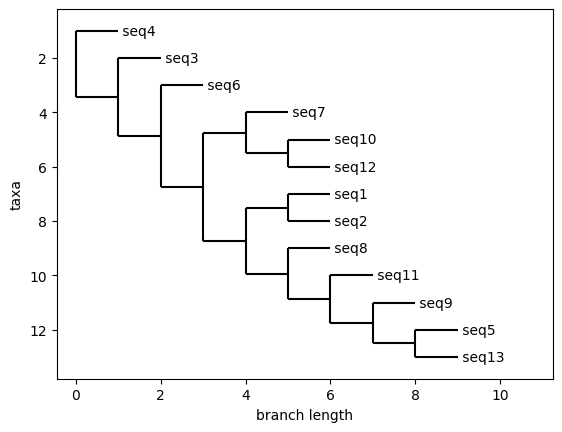

In [138]:
ma.draw_tree()

Ejemplo de como funciona con otras secuencias mas chicas

In [136]:
sqs_prot = [('NWKRKCYVWISACSYNEWIC', 'protein_1'),
            ('NWKRKCYVWISACSYNEWIC', 'protein_2'),
            ('NWKRKCYVWISACSYNEWIC', 'protein_3'),
            ('ACGYCYVWISACSYNEWIC', 'protein_4'),
            ('ACGIKCYVWISACSYNEWIC', 'protein_5')]
sqs_adn = [('TACCCTTCGCGCCTGCGTATTAGATGGCTTGCTGGAGGGGCAGGCTGAGA','seq1'),
           ('GTCGCGTTACTTTGTTTAGGGAGTTATACCATTGTTATGTTCTTAACCTT','seq2'),
           ('TACCCTTCGCGCCTGCGTATTAGATGGCTTGAGGGAGGGGCAGGCTGAGA','seq3'),
           ('GTCGCGTTACTTTGTTTAGGGAGTTATACCATTGTTATGTTCTTAACCTT','seq4'),
           ('AAATGCTTTTCGAACCGAAACGCGAAAAACATAGTATCACATTCGTCTGA','seq5')]

ma2 = MultipleAlignment(sqs_adn,"ADN")

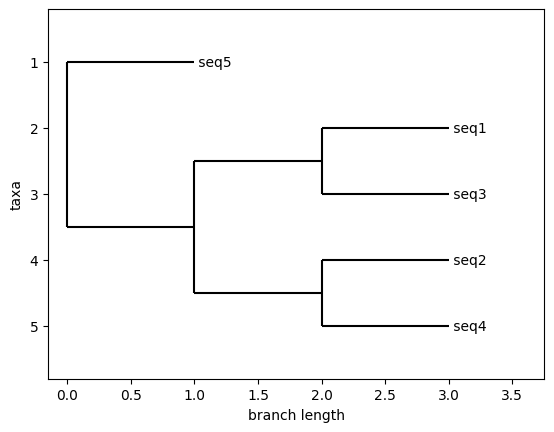

In [139]:
ma2.draw_tree()

### Comparación con alineamiento BLAST

In [612]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

# Convertir las secuencias en objetos SeqRecord
seq_records = [SeqRecord(seq[0], id=seq[1]) for seq in sequences]

# Crear un objeto MultipleSeqAlignment con las secuencias
alignment = MultipleSeqAlignment(seq_records)

# Calcular la matriz de distancias con el calculador de identidad
calculator = DistanceCalculator('identity')
distMatrix = calculator.get_distance(alignment)


In [609]:
print(distMatrix)

seq1    0.000000
seq2    0.933333    0.000000
seq3    0.866667    0.900000    0.000000
seq4    0.866667    0.966667    1.000000    0.000000
seq5    0.900000    0.933333    0.900000    0.966667    0.000000
seq6    0.966667    0.866667    0.933333    0.866667    0.866667    0.000000
seq7    0.900000    0.900000    0.933333    0.933333    0.900000    0.933333    0.000000
seq8    0.866667    0.966667    0.900000    0.933333    0.966667    0.933333    0.966667    0.000000
seq9    0.933333    0.966667    0.966667    0.933333    0.866667    0.933333    0.866667    1.000000    0.000000
seq10   0.900000    0.933333    0.966667    0.933333    0.933333    1.000000    0.966667    0.966667    1.000000    0.000000
seq11   0.966667    0.933333    0.966667    0.966667    0.900000    0.900000    0.933333    0.966667    1.000000    0.966667    0.000000
seq12   0.933333    0.966667    0.900000    1.000000    0.966667    0.933333    0.966667    0.966667    0.933333    0.833333    0.966667    0.000000
seq1

In [610]:
constructor = DistanceTreeConstructor()
UPGMATree = constructor.upgma(distMatrix)

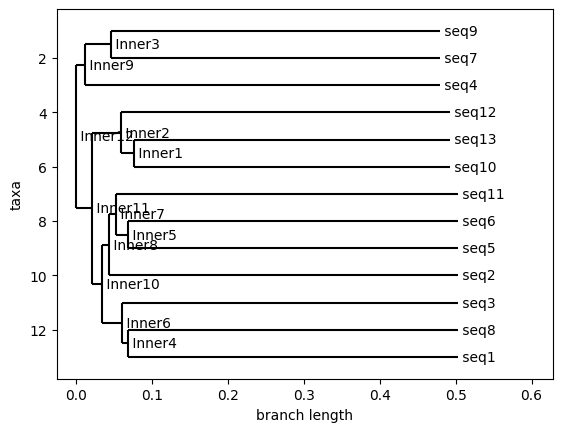

In [611]:
Phylo.draw(UPGMATree)